# eXponential Family Dynamical Systems (XFADS): Large-scale nonlinear Gaussian state-space modeling


<a target="_blank" href="https://colab.research.google.com/github/catniplab/NeuroTask/blob/main/xfads_tutorial/xfads_tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br>A low-rank structured variational autoencoding framework for nonlinear Gaussian state-space graphical models capable of capturing dense covariance structures that are important for learning dynamical systems with predictive capabilities. Furthermore, when applied to neural physiological recordings, XFADS is able to learn a dynamical system capable of forecasting population spiking and behavioral correlates from a small portion of single trials.<br>

Beyond inferring smoothed latent trajectories, XFADS leverages some quintessential properties of Probabilistic Graphical Models and the Exponential family.

With adequate configs and suitable choices of distributions for the SSM modules (as we will see below), you can fit XFADS on different spans of neural data.<br>

For an in-depth understanding of the underlying theory of this statistical framework, dive into the paper: [Dowling, Zhao, Park. 2024](https://arxiv.org/abs/2403.01371).<br>
For more info about the applications of XFADS see the public code ([GitHub repo](https://github.com/catniplab/xfads)).


In [84]:
import numpy as np
import pandas as pd
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.ndimage import gaussian_filter1d

import torch
import torch.nn as nn
import torch.nn.functional as Fn
import pytorch_lightning as lightning

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, GradientAccumulationScheduler

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


import xfads.utils as utils
import xfads.plot_utils as plot_utils
import xfads.prob_utils as prob_utils

from xfads.ssm_modules.likelihoods import PoissonLikelihood, GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM, LightningMonkeyReaching
from xfads.smoothers.nonlinear_smoother_causal import NonlinearFilter, LowRankNonlinearStateSpaceModel

import warnings
warnings.filterwarnings("ignore")

### Define training and model configuration

In [85]:
"""config"""
GlobalHydra.instance().clear()
initialize(version_base=None, config_path="", job_name="monkey_reaching")
cfg = compose(config_name="config")

lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1236


### Load Data Splits

In [86]:
"""load the data"""
data_path = '/home/makki/data/data_{split}_{bin_size_ms}ms.pt'
train_data = torch.load(data_path.format(split='train', bin_size_ms=cfg.bin_sz_ms))
val_data = torch.load(data_path.format(split='valid', bin_size_ms=cfg.bin_sz_ms))
test_data = torch.load(data_path.format(split='test', bin_size_ms=cfg.bin_sz_ms))

y_train_obs = train_data['y_obs'].type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc, :]
y_valid_obs = val_data['y_obs'].type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc, :]
y_test_obs = test_data['y_obs'].type(torch.float32).to(cfg.data_device)[:, :cfg.n_bins_enc, :]

"""Gaussian-smoothed spike trains"""
y_train_obs = torch.tensor(
    gaussian_filter1d(y_train_obs.cpu(), sigma=cfg.gaussian_kernel_ms//cfg.bin_sz_ms, axis=1)
)#.to(cfg.data_device)
y_valid_obs = torch.tensor(
    gaussian_filter1d(y_valid_obs.cpu(), sigma=cfg.gaussian_kernel_ms//cfg.bin_sz_ms, axis=1)
)#.to(cfg.data_device)
y_test_obs = torch.tensor(
    gaussian_filter1d(y_test_obs.cpu(), sigma=cfg.gaussian_kernel_ms//cfg.bin_sz_ms, axis=1)
)#.to(cfg.data_device)

vel_train = torch.stack((train_data['cursor_vel_x'], train_data['cursor_vel_y']), dim=-1)[:, :cfg.n_bins_enc, :]
vel_valid = torch.stack((val_data['cursor_vel_x'], val_data['cursor_vel_y']), dim=-1)[:, :cfg.n_bins_enc, :]
vel_test = torch.stack((test_data['cursor_vel_x'], test_data['cursor_vel_y']), dim=-1)[:, :cfg.n_bins_enc, :]

y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, vel_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, vel_valid)
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, vel_test)

train_dataloader = torch.utils.data.DataLoader(y_train_dataset, batch_size=cfg.batch_sz, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(y_val_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)
test_dataloader = torch.utils.data.DataLoader(y_test_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)

n_train_trials, n_bins, n_neurons_obs = y_train_obs.shape
n_valid_trials = y_valid_obs.shape[0]
n_test_trials = y_test_obs.shape[0]

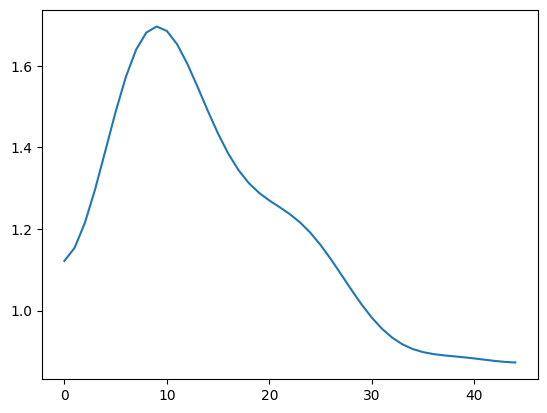

In [87]:
plt.plot(y_valid_obs.mean(dim=0)[:, 100])

### Define the structure of the state-space model

In [88]:
"""likelihood pdf"""
R_diag = torch.ones(n_neurons_obs, device=cfg.device)
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, nn.Linear(cfg.n_latents_read, n_neurons_obs))
#likelihood_pdf = PoissonLikelihood(readout_fn, n_neurons_obs, cfg.bin_sz, device=cfg.device)
likelihood_pdf = GaussianLikelihood(readout_fn, n_neurons_obs, R_diag, device=cfg.device)

"""dynamics module"""
Q_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

"""initial condition"""
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)
Q_0_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

"""local/backwar  d encoder"""
backward_encoder = BackwardEncoderLRMvn(cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
                                        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward,
                                        device=cfg.device)
local_encoder = LocalEncoderLRMvn(cfg.n_latents, n_neurons_obs, cfg.n_hidden_local, cfg.n_latents,
                                  rank=cfg.rank_local,
                                  device=cfg.device, dropout=cfg.p_local_dropout)
nl_filter = NonlinearFilter(dynamics_mod, initial_condition_pdf, device=cfg.device)

"""sequence vae"""
ssm = LowRankNonlinearStateSpaceModel(dynamics_mod, likelihood_pdf, initial_condition_pdf, backward_encoder,
                                      local_encoder, nl_filter, device=cfg.device)

### Load the trained model

In [89]:
"""lightning"""
model_ckpt_path = '~/xfsds_experiments/baselines/mc_20ms_gaussian_link/ckpts/smoother/acausal/last-v1.ckpt'
seq_vae = LightningNonlinearSSM.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                     n_time_bins_enc=cfg.n_bins_enc, bin_prd_start=cfg.n_bins_bhv,
                                                     strict=False)

"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

LowRankNonlinearStateSpaceModel(
  (nl_filter): NonlinearFilter(
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInitialCondition()
  )
  (dynamics_mod): DenseGaussianDynamics(
    (mean_fn): DynamicsGRU(
      (gru_cell): GRUCell(0, 128)
      (h_to_z): Linear(in_features=128, out_features=40, bias=True)
      (z_to_h): Linear(in_features=40, out_features=128, bias=True)
    )
  )
  (local_encoder): LocalEncoderLRMvn(
    (mlp): Sequential(
      (0): Linear(in_features=192, out_features=256, bias=True)
      (1): SiLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=256, out_features=640, bias=True)
    )
  )
  (initial_c_pdf): DenseGaussianInitialCondition()
  (likelihood_pdf): GaussianLikelihood(
    (readout_fn):

### Infering the latent trajectories and using them to generate corresponding observations

In [90]:
"""inference"""
z_s_train = []
z_f_train = []
z_p_train = []

rates_train_s = []
rates_train_f = []
rates_train_p = []

z_s_valid = []
z_f_valid = []
z_p_valid = []

rates_valid_s = []
rates_valid_f = []
rates_valid_p = []

z_s_test = []
z_f_test = []
z_p_test = []

rates_test_s = []
rates_test_f = []
rates_test_p = []

with torch.no_grad():
    m_0 = seq_vae.ssm.nl_filter.initial_c_pdf.m_0
    Q_0 = Fn.softplus(seq_vae.ssm.nl_filter.initial_c_pdf.log_Q_0)
    #m_0 = seq_vae.ssm.dynamics_mod.initial_c_pdf.m_0
    #Q_0 = Fn.softplus(seq_vae.ssm.dynamics_mod.initial_c_pdf.log_Q_0)

    z_ic = m_0 + Q_0.sqrt() * torch.randn([n_test_trials, n_neurons_obs] + [cfg.n_latents], device=cfg.device)
    #z_ic_p = seq_vae.ssm.predict_forward(z_ic, cfg.n_bins - cfg.n_bins_bhv)

    for batch_idx, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="train dataloader"):
        
        #print(f"\ntrain batch: {batch_idx + 1}")
        #print(f"Allocated: {torch.cuda.memory_allocated(0) / 1e9} GB   Reserved: {torch.cuda.memory_reserved(0) / 1e9} GB   Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1e9} GB")
        
        loss, z_s, stats = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_train.append(z_s.to('cpu'))
        z_f_train.append(z_f.to('cpu'))
        z_p_train.append(z_p.to('cpu'))
        
        rates_train_s.append(rates_s)
        rates_train_f.append(rates_f)
        rates_train_p.append(rates_p)

    for batch_idx, batch in tqdm(enumerate(valid_dataloader), total=len(test_dataloader), desc="valid dataloader"):
        
        #print(f"\nvalid batch: {batch_idx + 1}")
        #print(f"Allocated: {torch.cuda.memory_allocated(0) / 1e9} GB   Reserved: {torch.cuda.memory_reserved(0) / 1e9} GB   Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1e9} GB")
        
        loss, z_s, stats = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_valid.append(z_s.to('cpu'))
        z_f_valid.append(z_f.to('cpu'))
        z_p_valid.append(z_p.to('cpu'))
        
        rates_valid_s.append(rates_s)
        rates_valid_f.append(rates_f)
        rates_valid_p.append(rates_p)
        
    for batch_idx, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="test dataloader"):
        
        #print(f"\ntest batch: {batch_idx + 1}")
        #print(f"Allocated: {torch.cuda.memory_allocated(0) / 1e9} GB   Reserved: {torch.cuda.memory_reserved(0) / 1e9} GB   Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1e9} GB")
        
        loss, z_s, stats = seq_vae.ssm(batch[0].to(cfg.device), cfg.n_samples)
        z_f, stats = seq_vae.ssm.fast_filter_1_to_T(batch[0].to(cfg.device), cfg.n_samples)
        z_p = seq_vae.ssm.predict_forward(z_f[:, :, cfg.n_bins_bhv], cfg.n_bins - cfg.n_bins_bhv)
        z_p = torch.cat([z_f[:, :, :cfg.n_bins_bhv], z_p], dim=2)
        
        rates_s = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s)).mean(dim=0).to('cpu')
        rates_f = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f)).mean(dim=0).to('cpu')
        rates_p = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p)).mean(dim=0).to('cpu')
        
        z_s_test.append(z_s.to('cpu'))
        z_f_test.append(z_f.to('cpu'))
        z_p_test.append(z_p.to('cpu'))
        
        rates_test_s.append(rates_s)
        rates_test_f.append(rates_f)
        rates_test_p.append(rates_p)

test dataloader: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


In [91]:
z_s_train = torch.cat(z_s_train, dim=1).cpu()
z_f_train = torch.cat(z_f_train, dim=1).cpu()
z_p_train = torch.cat(z_p_train, dim=1).cpu()

rates_train_s = torch.cat(rates_train_s, dim=0).cpu()
rates_train_f = torch.cat(rates_train_f, dim=0).cpu()
rates_train_p = torch.cat(rates_train_p, dim=0).cpu()

z_s_valid = torch.cat(z_s_valid, dim=1).cpu()
z_f_valid = torch.cat(z_f_valid, dim=1).cpu()
z_p_valid = torch.cat(z_p_valid, dim=1).cpu()

rates_valid_s = torch.cat(rates_valid_s, dim=0).cpu()
rates_valid_f = torch.cat(rates_valid_f, dim=0).cpu()
rates_valid_p = torch.cat(rates_valid_p, dim=0).cpu()

z_s_test = torch.cat(z_s_test, dim=1).cpu()
z_f_test = torch.cat(z_f_test, dim=1).cpu()
z_p_test = torch.cat(z_p_test, dim=1).cpu()

rates_test_s = torch.cat(rates_test_s, dim=0).cpu()
rates_test_f = torch.cat(rates_test_f, dim=0).cpu()
rates_test_p = torch.cat(rates_test_p, dim=0).cpu()

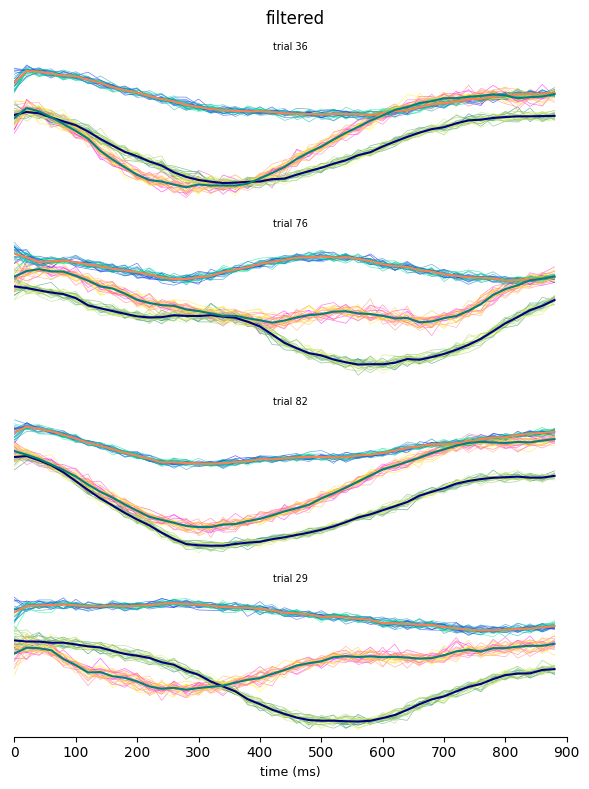

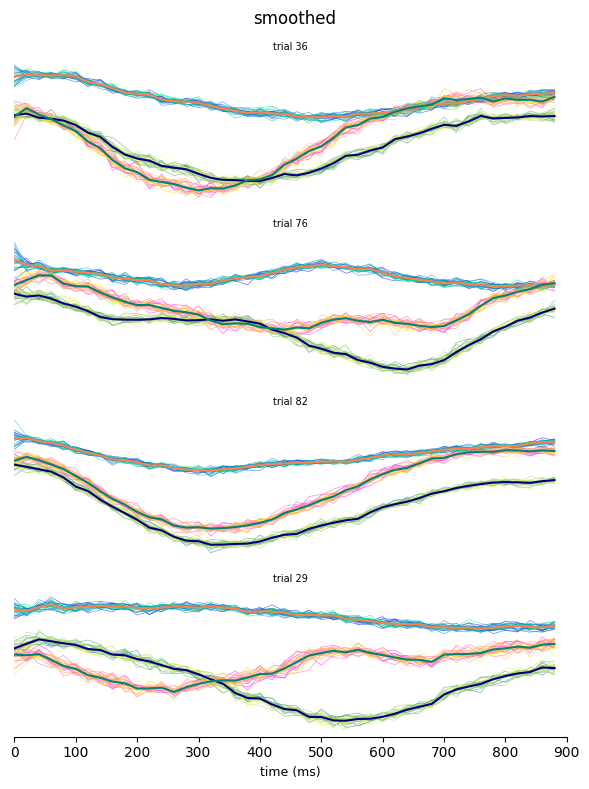

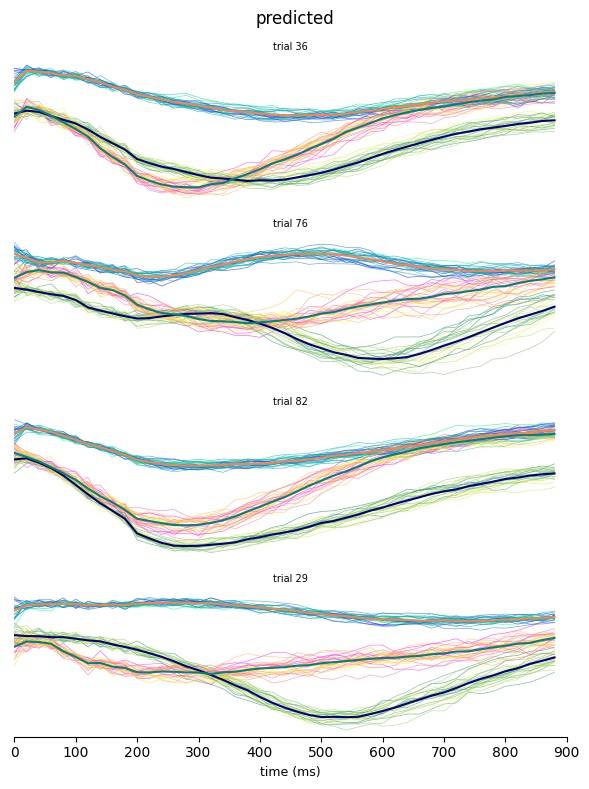

In [92]:
"""colors"""
blues = cm.get_cmap("winter", z_s_test.shape[0])
reds = cm.get_cmap("summer", z_s_test.shape[0])
springs = cm.get_cmap("spring", z_s_test.shape[0])

color_map_list = [blues, reds, springs]
event_c = ['purple', 'coral', 'navy']
colors = ['coral', 'navy', 'teal']

n_ex_trials = 4
trial_indcs = np.random.choice(range(0, y_test_obs.shape[0]), size=n_ex_trials)


def plot_z_samples(fig, axs, latents, trial_indcs, cfg, color_map_list, regime=None):
    
    samples = latents[:, trial_indcs, :, :3]
    n_samples, n_trials, n_bins, n_latents = samples.shape
    
    fig.subplots_adjust(hspace=0)
    
    [axs[i].axis('off') for i in range(n_trials-1)]
    axs[-1].yaxis.set_visible(False)
    axs[-1].spines['left'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    
    axs[-1].set_xlabel('time (ms)', fontsize=9)
    
    # Plot the 25 samples of each latent
    [axs[i].plot(np.arange(n_bins) * cfg.bin_sz_ms, samples[j, i, :, n], color=color_map_list[n](j), linewidth=0.5, alpha=0.6)
     for i in range(n_trials) for j in range(samples.shape[0]) for n in range(n_latents)]
    
    # On top of the 25 samples, plot the mean.
    [axs[i].plot(np.arange(n_bins) * cfg.bin_sz_ms, samples[:, i, :, n].mean(dim=0), color=colors[n], linewidth=1.5, alpha=1.0)
     for i in range(n_trials) for n in range(n_latents)]
    
    [axs[i].set_title(f'trial {trial_indcs[i]+1}', fontsize=7) for i in range(n_trials)]
    [axs[i].set_xlim(0, n_bins * cfg.bin_sz_ms,) for i in range(n_trials)]
        
"""filtered"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(6, 8))
plot_z_samples(fig, axs, z_f_test.cpu(), trial_indcs, cfg, color_map_list)
fig.suptitle('filtered')
fig.tight_layout()
#plt.savefig("output_figs/z_f_trajectory.png")
plt.show()

"""smoothed"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(6, 8))
plot_z_samples(fig, axs, z_s_test.cpu(), trial_indcs, cfg, color_map_list)
fig.suptitle('smoothed')
fig.tight_layout()
#plt.savefig("output_figs/z_s_trajectory.png")
plt.show()

"""predicted"""
fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(6, 8))
plot_z_samples(fig, axs, z_p_test.cpu(), trial_indcs, cfg, color_map_list)
fig.suptitle('predicted')
fig.tight_layout()
#plt.savefig("output_figs/z_p_trajectory.png")
plt.show()

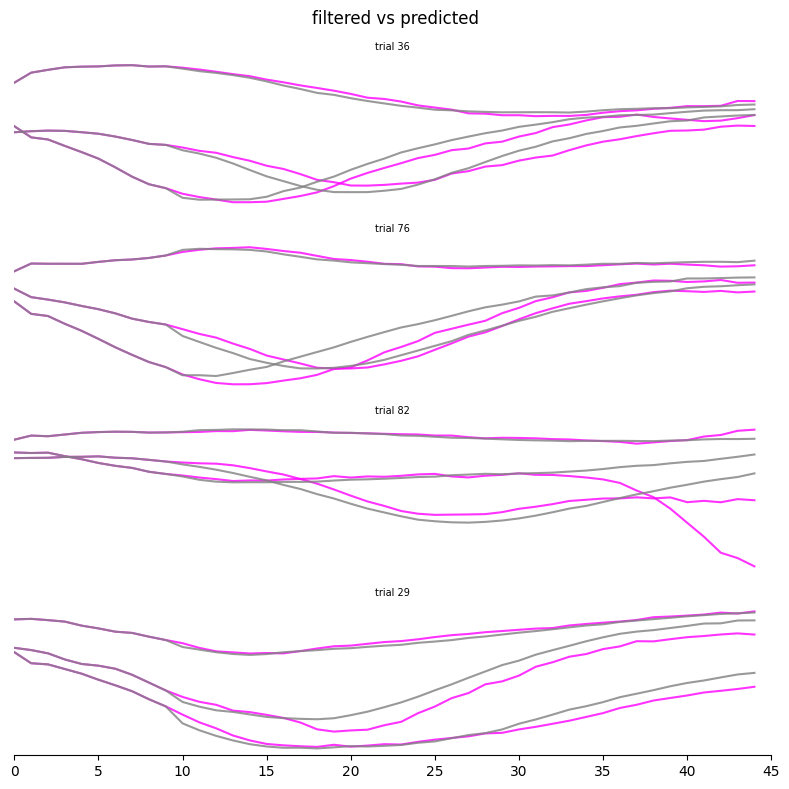

In [93]:
#n_ex_trials = 4
#trial_indcs = np.random.choice(range(0, y_test_obs.shape[0]), size=n_ex_trials, replace=False)

def plot_f_vs_p(fig, axs, z_f_z_p, trial_indcs, cfg, colors=None, regimes=None):
    
    samples = z_f_z_p[0][:, trial_indcs, ..., :3]
    n_samples, n_trials, n_bins, n_latents = samples.shape

    fig.subplots_adjust(hspace=0)
    
    [axs[i].axis('off') for i in range(n_trials-1)]
    axs[-1].yaxis.set_visible(False)
    axs[-1].spines['left'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    
    for ir, regime in enumerate(regimes):
        [axs[i].plot(z_f_z_p[ir][:, i, :, n].mean(dim=0), color=colors[ir], linewidth=1.5, alpha=0.8, label=regime if ir==0 and i==0 and n==0 else '')
         for i in range(n_trials) for n in range(n_latents)]
    
    [axs[i].set_title(f'trial {trial_indcs[i]+1}', fontsize=7) for i in range(n_trials)]
    [axs[i].set_xlim(0, n_bins) for i in range(n_trials)]


fig, axs = plt.subplots(len(trial_indcs), 1, figsize=(8, 8))
plot_f_vs_p(fig, axs, [z_f_test, z_p_test], trial_indcs, cfg, colors=['magenta', 'gray'], regimes=['filtering', 'prediction'])
fig.suptitle(f'filtered vs predicted')
fig.tight_layout()
#plt.savefig("output_figs/f_vs_p.png")
plt.show()

### Metrices

In [94]:
metrices = pd.read_csv("~/xfsds_experiments/baselines/mc_20ms_gaussian_link/logs/smoother/acausal/sd_1236_r_y_15_r_b_5/smoother_acausal/metrics.csv")

Text(0, 0.5, 'ELBO')

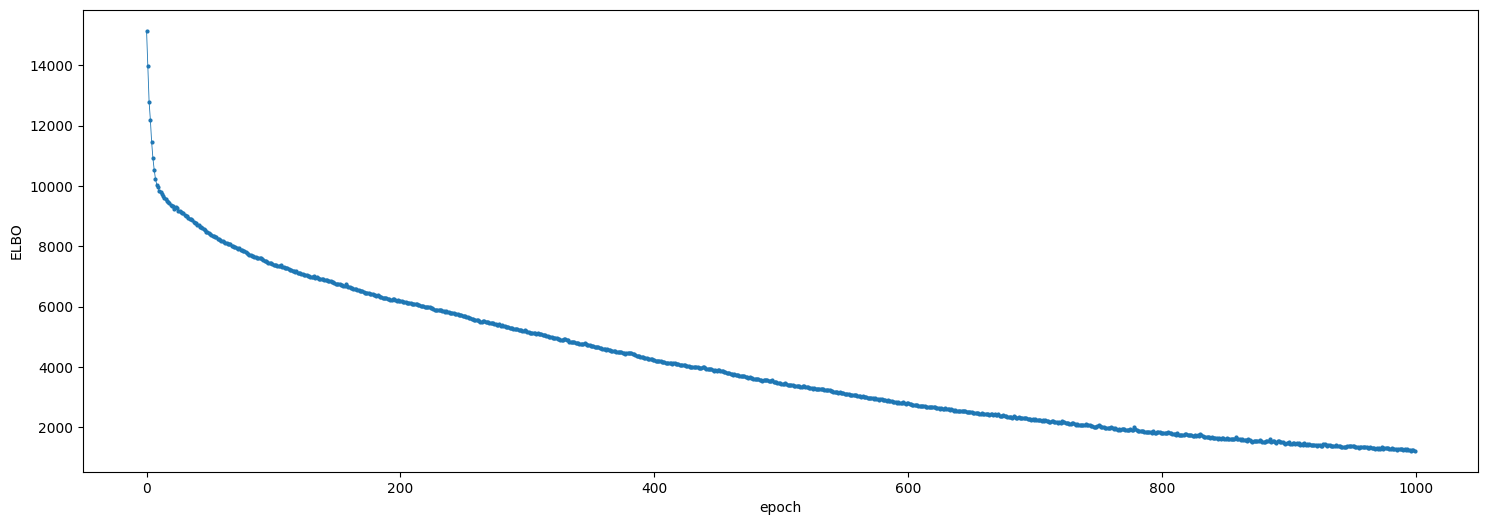

In [95]:
ll = pd.read_csv("~/xfsds_experiments/baselines/mc_20ms_gaussian_link/logs/smoother_acausal/sd_1236_r_y_15_r_b_5/metrics_0.0mask.csv")['valid_loss'].values
plt.figure(figsize=(18, 6))
plt.plot(ll[~np.isnan(ll)], marker='o', markersize=2, linestyle='-', linewidth=0.6)
plt.xlabel('epoch')
plt.ylabel('ELBO')

Text(0, 0.5, 'ELBO')

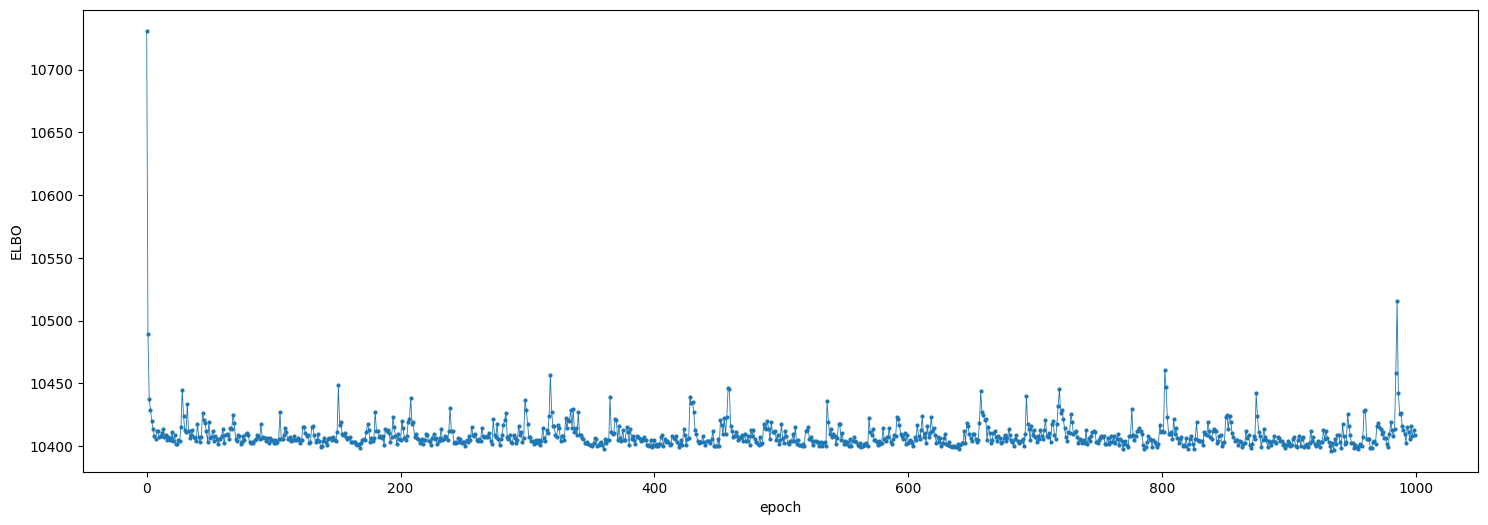

In [96]:
ll = pd.read_csv("~/xfsds_experiments/baselines/mc_20ms_gaussian_link/logs/smoother_acausal/sd_1236_r_y_15_r_b_5/metrics_0.2mask.csv")['valid_loss'].values
plt.figure(figsize=(18, 6))
plt.plot(ll[~np.isnan(ll)], marker='o', markersize=2, linestyle='-', linewidth=0.6)
plt.xlabel('epoch')
plt.ylabel('ELBO')

Text(0, 0.5, 'ELBO')

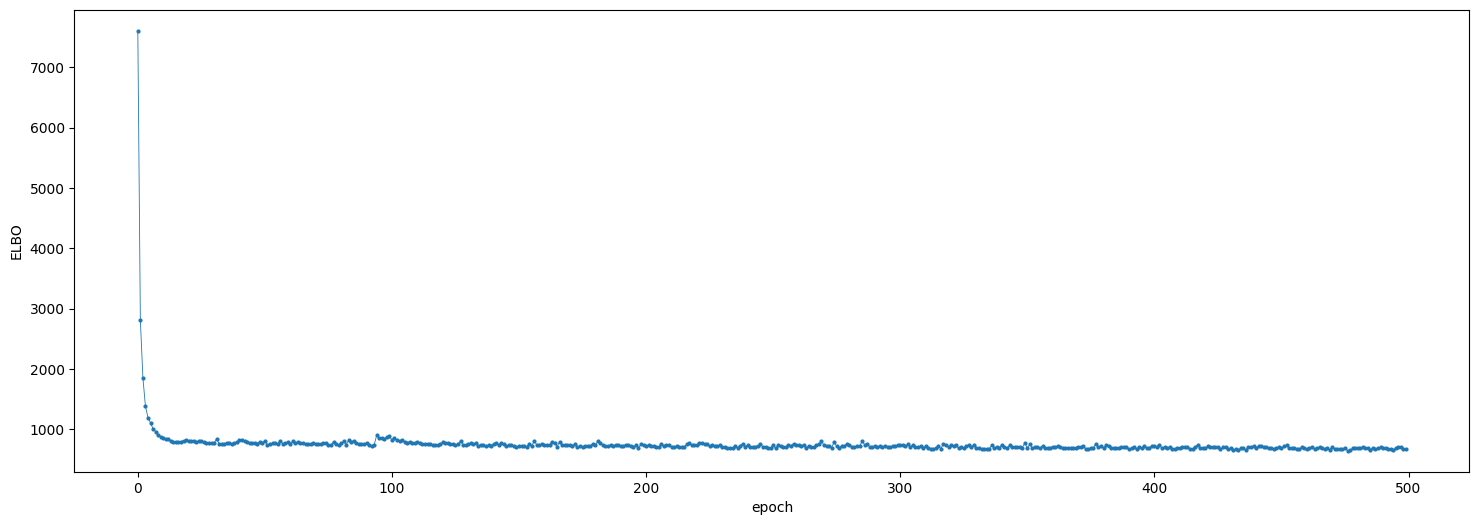

In [97]:
ll = pd.read_csv("~/xfsds_experiments/baselines/mc_20ms_gaussian_link/logs/smoother_acausal/sd_1236_r_y_15_r_b_5/metrics_0.4mask.csv")['valid_loss'].values
plt.figure(figsize=(18, 6))
plt.plot(ll[~np.isnan(ll)], marker='o', markersize=2, linestyle='-', linewidth=0.6)
plt.xlabel('epoch')
plt.ylabel('ELBO')

Text(0, 0.5, 'ELBO')

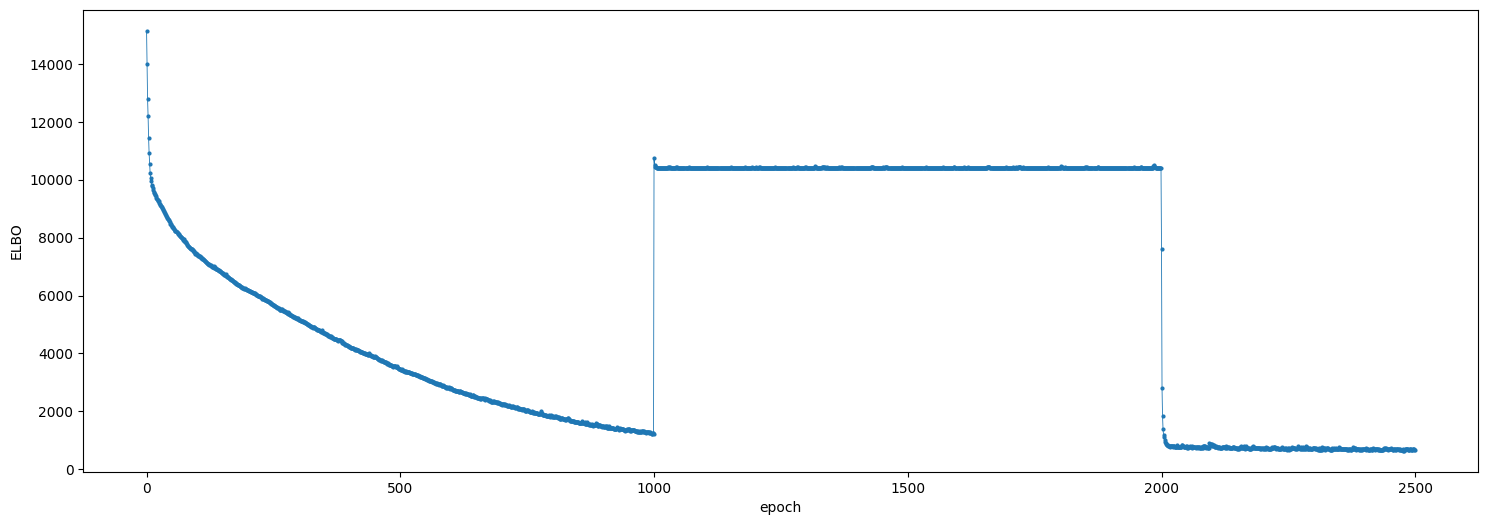

In [98]:
ll = np.concatenate(
    (pd.read_csv("~/xfsds_experiments/baselines/mc_20ms_gaussian_link/logs/smoother_acausal/sd_1236_r_y_15_r_b_5/metrics_0.0mask.csv")['valid_loss'].values,
     pd.read_csv("~/xfsds_experiments/baselines/mc_20ms_gaussian_link/logs/smoother_acausal/sd_1236_r_y_15_r_b_5/metrics_0.2mask.csv")['valid_loss'].values,
     pd.read_csv("~/xfsds_experiments/baselines/mc_20ms_gaussian_link/logs/smoother_acausal/sd_1236_r_y_15_r_b_5/metrics_0.4mask.csv")['valid_loss'].values),
     axis=0)
plt.figure(figsize=(18, 6))
plt.plot(ll[~np.isnan(ll)], marker='o', markersize=2, linestyle='-', linewidth=0.6)
plt.xlabel('epoch')
plt.ylabel('ELBO')

### Velocity decoder

In [99]:
clf = Ridge(alpha=1.0)
# fit to training data
clf.fit(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    
with torch.no_grad():
    r2 = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    
    r2_train = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_valid = clf.score(rates_valid_s.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_test = clf.score(rates_test_s.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    
    r2_filter = clf.score(rates_test_f.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_k_step = []
    
    # transform train data
    r2_train_s = clf.score(rates_train_s.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_train_f = clf.score(rates_train_f.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    r2_train_p = clf.score(rates_train_p.reshape(-1, n_neurons_obs), vel_train.reshape(-1, 2))
    vel_hat_train_s = clf.predict(rates_train_s.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    vel_hat_train_f = clf.predict(rates_train_f.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    vel_hat_train_p = clf.predict(rates_train_p.reshape(-1, n_neurons_obs)).reshape(list(y_train_obs.shape)[:-1] + [vel_train.shape[-1]])
    
    # transform valid data
    r2_valid_s = clf.score(rates_valid_s.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_valid_f = clf.score(rates_valid_f.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    r2_valid_p = clf.score(rates_valid_p.reshape(-1, n_neurons_obs), vel_valid.reshape(-1, 2))
    vel_hat_valid_s = clf.predict(rates_valid_s.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    vel_hat_valid_f = clf.predict(rates_valid_f.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    vel_hat_valid_p = clf.predict(rates_valid_p.reshape(-1, n_neurons_obs)).reshape(list(y_valid_obs.shape)[:-1] + [vel_valid.shape[-1]])
    
    # transform test data
    r2_test_s = clf.score(rates_test_s.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_test_f = clf.score(rates_test_f.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    r2_test_p = clf.score(rates_test_p.reshape(-1, n_neurons_obs), vel_test.reshape(-1, 2))
    vel_hat_test_s = clf.predict(rates_test_s.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    vel_hat_test_f = clf.predict(rates_test_f.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    vel_hat_test_p = clf.predict(rates_test_p.reshape(-1, n_neurons_obs)).reshape(list(y_test_obs.shape)[:-1] + [vel_test.shape[-1]])
    
    for k in range(cfg.n_bins_enc):
        z_prd_test = utils.propagate_latent_k_steps(z_f_valid[:, :, k], dynamics_mod.to('cpu'), n_bins + 0 - (k + 1))
        z_prd_test = torch.concat([z_f_valid[:, :, :k], z_prd_test], dim=2)

        # m_prd_test = z_prd_test.mean(dim=0)
        # m_prd_test = torch.concat([m_filter[:, :k], m_prd_test[:, k:]], dim=1)

        rates_prd_test = torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_prd_test.to(cfg.device))).mean(dim=0)

        r2_prd = clf.score(rates_prd_test.reshape(-1, n_neurons_obs).cpu(), vel_valid.reshape(-1, 2))
        r2_k_step.append(r2_prd)

In [100]:
vel_to_pos = lambda v: torch.cumsum(torch.tensor(v), dim=1)

vel = torch.concat([vel_train, vel_valid, vel_test], dim=0)

pos_train = vel_to_pos(vel_train)
pos_valid = vel_to_pos(vel_valid)
pos_test = vel_to_pos(vel_test)

pos = torch.concat([pos_train, pos_valid, pos_test], dim=0)

pos_train_hat_s = vel_to_pos(vel_hat_train_s)
pos_train_hat_f = vel_to_pos(vel_hat_train_f)
pos_train_hat_p = vel_to_pos(vel_hat_train_p)

pos_valid_hat_s = vel_to_pos(vel_hat_valid_s)
pos_valid_hat_f = vel_to_pos(vel_hat_valid_f)
pos_valid_hat_p = vel_to_pos(vel_hat_valid_p)

pos_test_hat_s = vel_to_pos(vel_hat_test_s)
pos_test_hat_f = vel_to_pos(vel_hat_test_f)
pos_test_hat_p = vel_to_pos(vel_hat_test_p)

pos_hat_s = torch.concat([pos_train_hat_s, pos_valid_hat_s, pos_test_hat_s], dim=0)
pos_hat_f = torch.concat([pos_train_hat_f, pos_valid_hat_f, pos_test_hat_f], dim=0)
pos_hat_p = torch.concat([pos_train_hat_p, pos_valid_hat_p, pos_test_hat_p], dim=0)

reach_angles_rad = torch.atan2(pos[:, -1, 0], pos[:, -1, 1])
reach_angles_deg = torch.rad2deg(reach_angles_rad) + 360 / 2

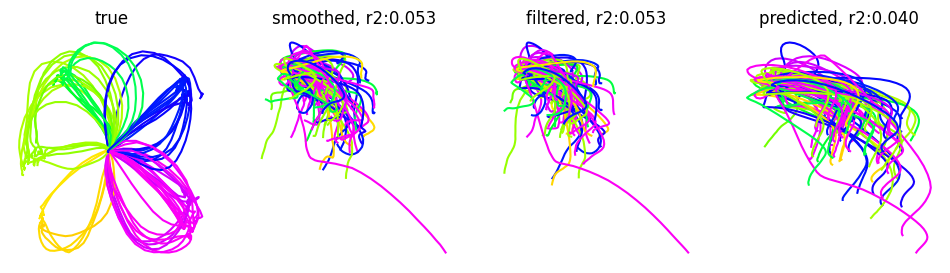

In [101]:
"""plotting"""
n_trials_plot = 80
n_samples_mu_plt = 20

blues = cm.get_cmap("Blues", n_samples_mu_plt)
grays = cm.get_cmap("Greys", n_samples_mu_plt)
yellows = cm.get_cmap("YlOrBr", n_samples_mu_plt)

trial_plt_dx = torch.randperm(n_test_trials)[:n_trials_plot]
reach_angle = torch.atan2(pos_train[:, -1, 0], pos_train[:, -1, 1])
reach_colors = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

with torch.no_grad():
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    plot_utils.plot_reaching(axs[0], pos_train[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[1], pos_train_hat_s[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[2], pos_train_hat_f[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[3], pos_train_hat_p[trial_plt_dx], reach_colors[trial_plt_dx])

    axs[0].set_title('true')
    axs[1].set_title(f'smoothed, r2:{r2_train_s:.3f}')
    axs[2].set_title(f'filtered, r2:{r2_train_f:.3f}')
    axs[3].set_title(f'predicted, r2:{r2_train_p:.3f}')
    
    #plt.savefig('output_figs/reach_trajectories.png')
    plt.show()

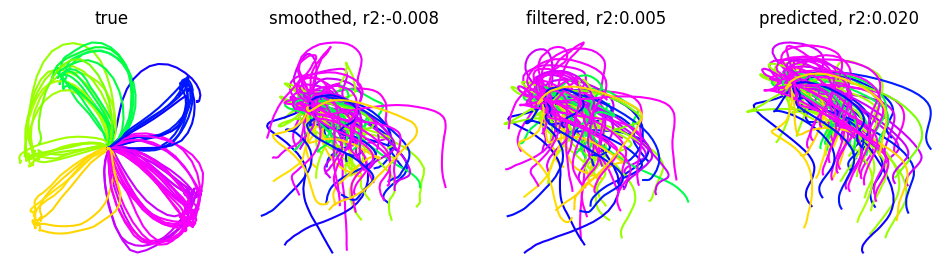

In [102]:
"""plotting"""
n_trials_plot = 80
n_samples_mu_plt = 20

blues = cm.get_cmap("Blues", n_samples_mu_plt)
grays = cm.get_cmap("Greys", n_samples_mu_plt)
yellows = cm.get_cmap("YlOrBr", n_samples_mu_plt)

trial_plt_dx = torch.randperm(n_test_trials)[:n_trials_plot]
reach_angle = torch.atan2(pos_test[:, -1, 0], pos_test[:, -1, 1])
reach_colors = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

with torch.no_grad():
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    plot_utils.plot_reaching(axs[0], pos_test[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[1], pos_test_hat_s[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[2], pos_test_hat_f[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[3], pos_test_hat_p[trial_plt_dx], reach_colors[trial_plt_dx])

    axs[0].set_title('true')
    axs[1].set_title(f'smoothed, r2:{r2_test_s:.3f}')
    axs[2].set_title(f'filtered, r2:{r2_test_f:.3f}')
    axs[3].set_title(f'predicted, r2:{r2_test_p:.3f}')
    
    #plt.savefig('output_figs/reach_trajectories.png')
    plt.show()

In [103]:
plt.axvline(b_test[0, 1], linestyle='--')
plt.plot(r2_k_step)
plt.axhline(r2_test, color='green', label='smoothed')
plt.axhline(r2_filter, color='orange', label='filtered')
plt.title(f'r2 {cfg.n_bins_enc} steps\n')
plt.ylabel('r2')
plt.xlabel('context window size (t bins)')
plt.legend()

#plt.savefig(f'output_figs/r2_{cfg.n_bins_enc}_steps.png')
plt.show()

NameError: name 'b_test' is not defined